<a href="https://colab.research.google.com/github/mafecala/compuvisual/blob/master/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Por favor, sube una imagen:


No se subió ninguna imagen, usando imagen de ejemplo: https://www.freejpg.com.ar/asset/900/45/459d/F100010434.jpg


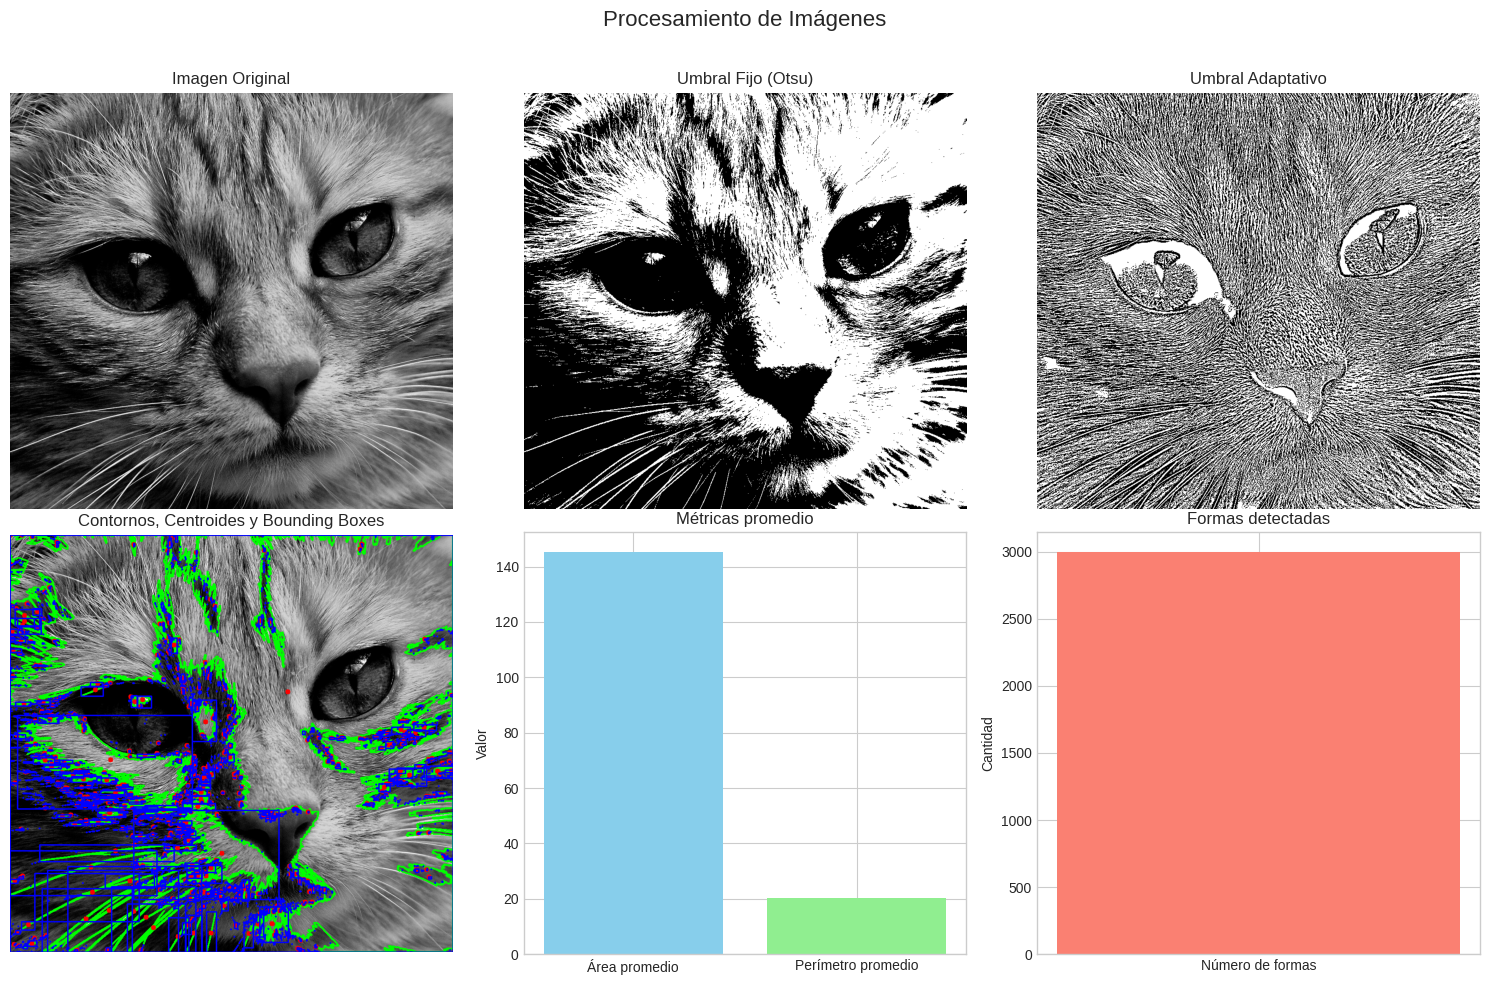

Número de formas detectadas: 2996
Área promedio: 145.17
Perímetro promedio: 20.30


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import urllib.request
from google.colab import files

# Configurar el estilo de las gráficas de matplotlib
plt.style.use('seaborn-v0_8-whitegrid')

def cargar_imagen(ruta=None):
    """
    Carga una imagen desde una URL o un archivo local.

    Args:
        ruta: Ruta o URL de la imagen. Si es None, permite subir una imagen.

    Returns:
        Imagen cargada en escala de grises
    """
    if ruta is None:
        print("Por favor, sube una imagen:")
        uploaded = files.upload()
        if not uploaded:
            # Si no se sube una imagen, usar una imagen de ejemplo
            url = "https://www.freejpg.com.ar/asset/900/45/459d/F100010434.jpg"
            print(f"No se subió ninguna imagen, usando imagen de ejemplo: {url}")
            req = urllib.request.urlopen(url)
            arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
            img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
        else:
            file_name = next(iter(uploaded))
            img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    elif ruta.startswith(('http://', 'https://')):
        # Cargar desde URL
        req = urllib.request.urlopen(ruta)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_GRAYSCALE)
    else:
        # Cargar desde un archivo local
        img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)

    # Verificar que la imagen se haya cargado correctamente
    if img is None:
        raise ValueError("No se pudo cargar la imagen.")

    return img

def aplicar_umbrales(imagen):
    """
    Aplica umbralización fija y adaptativa a una imagen en escala de grises.

    Args:
        imagen: Imagen en escala de grises

    Returns:
        Tupla con la imagen umbralizada fija y adaptativa
    """
    # Aplicar umbral fijo (Otsu)
    _, umbral_fijo = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Aplicar umbral adaptativo
    umbral_adaptativo = cv2.adaptiveThreshold(
        imagen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    return umbral_fijo, umbral_adaptativo

def detectar_contornos(imagen_binaria):
    """
    Detecta contornos en una imagen binaria.

    Args:
        imagen_binaria: Imagen binaria

    Returns:
        Lista de contornos
    """
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contornos

def calcular_metricas(contornos):
    """
    Calcula métricas para los contornos detectados.

    Args:
        contornos: Lista de contornos

    Returns:
        Diccionario con las métricas calculadas
    """
    num_formas = len(contornos)
    areas = []
    perimetros = []
    centroides = []
    bounding_boxes = []

    for contorno in contornos:
        # Calcular área
        area = cv2.contourArea(contorno)
        areas.append(area)

        # Calcular perímetro
        perimetro = cv2.arcLength(contorno, True)
        perimetros.append(perimetro)

        # Calcular centroide (centro de masa)
        M = cv2.moments(contorno)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0
        centroides.append((cx, cy))

        # Calcular bounding box
        x, y, w, h = cv2.boundingRect(contorno)
        bounding_boxes.append((x, y, w, h))

    # Calcular promedios
    area_promedio = np.mean(areas) if areas else 0
    perimetro_promedio = np.mean(perimetros) if perimetros else 0

    return {
        "num_formas": num_formas,
        "areas": areas,
        "perimetros": perimetros,
        "area_promedio": area_promedio,
        "perimetro_promedio": perimetro_promedio,
        "centroides": centroides,
        "bounding_boxes": bounding_boxes
    }

def dibujar_resultados(imagen_original, contornos, centroides, bounding_boxes):
    """
    Dibuja contornos, centroides y bounding boxes en la imagen original.

    Args:
        imagen_original: Imagen original en escala de grises
        contornos: Lista de contornos
        centroides: Lista de centroides (cx, cy)
        bounding_boxes: Lista de bounding boxes (x, y, w, h)

    Returns:
        Imagen con los resultados dibujados
    """
    # Convertir imagen a color para dibujar en colores diferentes
    imagen_resultado = cv2.cvtColor(imagen_original, cv2.COLOR_GRAY2BGR)

    # Dibujar contornos
    cv2.drawContours(imagen_resultado, contornos, -1, (0, 255, 0), 2)

    # Dibujar centroides
    for centro in centroides:
        cv2.circle(imagen_resultado, centro, 5, (0, 0, 255), -1)

    # Dibujar bounding boxes
    for bbox in bounding_boxes:
        x, y, w, h = bbox
        cv2.rectangle(imagen_resultado, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return imagen_resultado

def visualizar_resultados(imagen_original, umbral_fijo, umbral_adaptativo,
                         imagen_resultado, metricas, titulo="Procesamiento de Imágenes"):
    """
    Visualiza los resultados del procesamiento de imágenes.

    Args:
        imagen_original: Imagen original en escala de grises
        umbral_fijo: Imagen con umbral fijo aplicado
        umbral_adaptativo: Imagen con umbral adaptativo aplicado
        imagen_resultado: Imagen con contornos, centroides y bounding boxes
        metricas: Diccionario con métricas calculadas
        titulo: Título de la figura
    """
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(titulo, fontsize=16)

    # Mostrar imágenes
    ax1 = plt.subplot(2, 3, 1)
    ax1.imshow(imagen_original, cmap='gray')
    ax1.set_title('Imagen Original')
    ax1.axis('off')

    ax2 = plt.subplot(2, 3, 2)
    ax2.imshow(umbral_fijo, cmap='gray')
    ax2.set_title('Umbral Fijo (Otsu)')
    ax2.axis('off')

    ax3 = plt.subplot(2, 3, 3)
    ax3.imshow(umbral_adaptativo, cmap='gray')
    ax3.set_title('Umbral Adaptativo')
    ax3.axis('off')

    ax4 = plt.subplot(2, 3, 4)
    ax4.imshow(cv2.cvtColor(imagen_resultado, cv2.COLOR_BGR2RGB))
    ax4.set_title('Contornos, Centroides y Bounding Boxes')
    ax4.axis('off')

    # Mostrar gráficas de métricas
    ax5 = plt.subplot(2, 3, 5)
    ax5.bar(['Área promedio', 'Perímetro promedio'],
           [metricas['area_promedio'], metricas['perimetro_promedio']],
           color=['skyblue', 'lightgreen'])
    ax5.set_title('Métricas promedio')
    ax5.set_ylabel('Valor')

    ax6 = plt.subplot(2, 3, 6)
    ax6.bar(['Número de formas'], [metricas['num_formas']], color='salmon')
    ax6.set_title('Formas detectadas')
    ax6.set_ylabel('Cantidad')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Mostrar métricas en consola
    print(f"Número de formas detectadas: {metricas['num_formas']}")
    print(f"Área promedio: {metricas['area_promedio']:.2f}")
    print(f"Perímetro promedio: {metricas['perimetro_promedio']:.2f}")

def procesamiento_completo(ruta_imagen=None):
    """
    Realiza el procesamiento completo de una imagen.

    Args:
        ruta_imagen: Ruta o URL de la imagen. Si es None, permite subir una imagen.
    """
    # Cargar imagen
    imagen = cargar_imagen(ruta_imagen)

    # Aplicar umbrales
    umbral_fijo, umbral_adaptativo = aplicar_umbrales(imagen)

    # Detectar contornos (usamos el umbral fijo para este ejemplo)
    contornos = detectar_contornos(umbral_fijo)

    # Calcular métricas
    metricas = calcular_metricas(contornos)

    # Dibujar resultados
    imagen_resultado = dibujar_resultados(
        imagen, contornos, metricas['centroides'], metricas['bounding_boxes']
    )

    # Visualizar resultados
    visualizar_resultados(
        imagen, umbral_fijo, umbral_adaptativo, imagen_resultado, metricas
    )

    return imagen, umbral_fijo, umbral_adaptativo, imagen_resultado, metricas

# Ejecutar el procesamiento completo
if __name__ == "__main__":
    # Puedes especificar una URL o ruta de archivo, o dejar None para subir una imagen
    # Por ejemplo: procesamiento_completo("https://ejemplo.com/imagen.jpg")
    procesamiento_completo()